In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
import sys
import pdb
from copy import deepcopy
from tqdm import tqdm
import astropy.units as u
import mpl_scatter_density

import seaborn as sns
plt.style.use('seaborn')

In [2]:
sys.path.append('/Users/alexh')
import PyXFocus.sources as sources
import PyXFocus.transformations as trans
import PyXFocus.surfaces as surfaces
import PyXFocus.analyses as analyses
import PyXFocus.conicsolve as conic

import OGRE.ogre_routines_alexplay as ogre

soxs : [WARNING  ] 2023-10-20 15:51:36,543 Setting 'soxs_data_dir' to /Users/alexh/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
# Define PSO optic parameters.
z0 = 3500. * u.mm  # Focal length.

r_int = np.array([185.836, 191.305]) * u.mm #Radius at intersection node


mirror_length = 100 * u.mm  # Axial length of primary / secondary mirror.
mirror_sep = 5 * u.mm  # Separation between primary and secondary mirrors.


# PANTER Parameters
L = (123000. + 12000) * u.mm  # Approximate.
L -= 4000. * u.mm  # Accounts for focal length of optic in the finite conjugate.
#L = 10e12 * u.mm

#wave = 0.98903  # [nm] Mg-K wavelength.
wave = 0.83401 * u.nm # Al-K wavelength.

print(r_int)
print(L)

[185.836 191.305] mm
131000.0 mm


In [4]:
# Define inner and outer subannulus radii.
z_in = z0 + mirror_sep/2
z_out = z_in + mirror_length

print(z_in)
print(z_out)

r_in = conic.primrad(z_in, r_int[0], z0)
r_out = conic.primrad(z_out, r_int[-1], z0) #-1 is the last value in array 

print(r_in)
print(r_out)

3502.5 mm
3602.5 mm
185.86915285426616 mm
192.69923985012488 mm


In [5]:
dphi = 30 * u.deg

#not sure if this is entirely correct -- by math it seems like it is more aroun 27 degrees maybe? 
#Idk how much of an impact this change would have, but ig I'll find out 

In [6]:
# Define subannulus of rays.
rays = sources.subannulus(r_in.to('mm').value, r_out.to('mm').value,
                          dphi.to('rad').value, 500000)

In [7]:
# Rotate so that dispersion direction is in the x-dimension.
trans.transform(rays, 0, 0, 0, 0, 0, -np.pi/2)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 36.78455819,  44.61242458, -43.06453132, ..., -22.02900044,
         16.47403321,  32.55765596]),
 array([183.56505389, 182.76633504, 181.24373741, ..., 189.30200864,
        191.24794603, 183.74334179]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

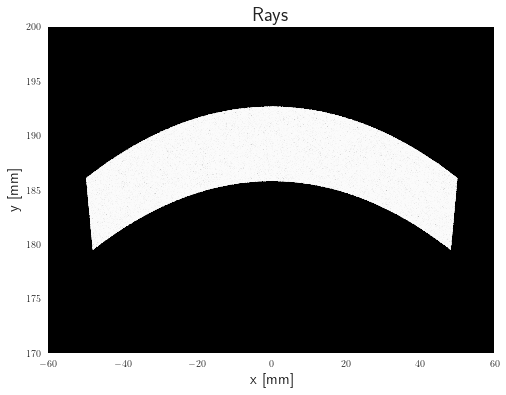

In [8]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,6))

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_xlim(-60,60)
    ax1.set_ylim(170,200)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

In [9]:
# Find centroid of rays and move rays down to center of beamline.
cen_optic = analyses.centroid(rays)
trans.transform(rays, 0, cen_optic[1], 0, 0, 0, 0)

In [10]:
# Change ray direction cosines to emanate from source (48 m away). Long cell
# Change ray direction cosines to emanate from source (131 m away). PANTER
hyp = np.sqrt(L.to('mm').value**2 + rays[1]**2 + rays[2]**2)
l = rays[1]/hyp
m = rays[2]/hyp
n = -np.sqrt(1. - l**2 - m**2)
rays = [rays[0], rays[1], rays[2], rays[3],
        l, m, n, rays[7], rays[8], rays[9]]

In [11]:
# Shift rays back up.
trans.transform(rays, 0, -cen_optic[1], 0, 0, 0, 0)

# Move to intersection node.
trans.transform(rays, 0, 0, -z0.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 36.78455819,  44.61242458, -43.06453132, ..., -22.02900044,
         16.47403321,  32.55765596]),
 array([183.56505389, 182.76633504, 181.24373741, ..., 189.30200864,
        191.24794603, 183.74334179]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([ 0.0002808 ,  0.00034055, -0.00032874, ..., -0.00016816,
         0.00012576,  0.00024853]),
 array([-2.73436086e-05, -3.34406982e-05, -4.50635803e-05, ...,
         1.64499378e-05,  3.13044216e-05, -2.59826326e-05]),
 array([-0.99999996, -0.99999994, -0.99999994, ..., -0.99999999,
        -0.99999999, -0.99999997]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [12]:

# Give telescope a slight pitch misalignment.
#2 arcmin misalignment.
pitch_val = (-30/60)

rays[5] = np.full(len(rays[5]), np.radians(pitch_val))
rays[6] = np.sqrt(1 - rays[5]**2) #renormalization
#rays[6] = np.sqrt(1 - (rays[5]**2 + rays[4]**2)) 
#3d sphere have to subtract the x compontent and y component addativley for z to be one 

#rays[5] = np.ones(len(rays[5])) * pitch_val
#rays[6] = np.sqrt(1 - rays[5]**2)


'\n# Give telescope a slight pitch misalignment.\n#2 arcmin misalignment.\npitch_val = (-30/60)\n\nrays[5] = np.full(len(rays[5]), np.radians(pitch_val))\nrays[6] = np.sqrt(1 - rays[5]**2)\n\n#rays[5] = np.ones(len(rays[5])) * pitch_val\n#rays[6] = np.sqrt(1 - rays[5]**2)\n'

In [13]:
# Define blank PyXFocus ray object.
new_rays = sources.annulus(0,0,0) 

# Define mirror parameters.
zp_back = z0 + mirror_sep/2  # Axial position of parabola front.
zp_front = zp_back + mirror_length  # axial position of parabola back.

rp_front = [conic.primrad(zp_front, r, z0) for r in r_int]
rp_back = [conic.primrad(zp_back, r, z0) for r in r_int]

#applies conic.primrad to 

print(zp_front)
print(zp_back)

print(rp_front)
print(rp_back)

print(r_in)
print(r_out)

3602.5 mm
3502.5 mm
[<Quantity 187.19045236 mm>, <Quantity 192.69923985 mm>]
[<Quantity 185.86915285 mm>, <Quantity 191.33912672 mm>]
185.86915285426616 mm
192.69923985012488 mm


Text(0.5, 1.0, 'title')

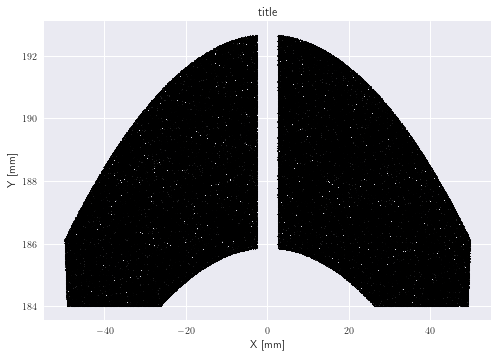

In [14]:
# cut out center section 

mask_h = 184*u.mm # dependent on y coordinate system here
mask_w = 5*u.mm

ind = np.where((np.abs(rays[1]) > mask_w.value/2) & (np.abs(rays[2])> mask_h.value) )

#ind_1 = np.where((np.abs(som1[1]) > mask_w.value/2) & (np.abs(som1[2])> mask_h.value) )
#ind_2 = np.where((np.abs(som2[1]) > mask_w.value/2) & (np.abs(som2[2])> mask_h.value) )

#ind_1 = np.where((np.abs(som1[1]) > mask_w.value/2))
#ind_2 = np.where((np.abs(som2[1]) > mask_w.value/2))


#som1 = [som1[0][ind_1], som1[1][ind_1], som1[2][ind_1], som1[3][ind_1], som1[4][ind_1], som1[5][ind_1], som1[6][ind_1], som1[7][ind_1], som1[8][ind_1], som1[9][ind_1]]
#som2 = [som2[0][ind_2], som2[1][ind_2], som2[2][ind_2], som2[3][ind_2], som2[4][ind_2], som2[5][ind_2], som2[6][ind_2], som2[7][ind_2], som2[8][ind_2], som2[9][ind_2]]

rays = [rays[0][ind], rays[1][ind], rays[2][ind], rays[3][ind], rays[4][ind], rays[5][ind], rays[6][ind], rays[7][ind], rays[8][ind], rays[9][ind]]

# Plot rays at this position.
plt.figure()
#plt.scatter(som1[1][ind_1], som1[2][ind_1], s=0.5, c='k')
#plt.scatter(som2[1][ind_2], som2[2][ind_2], s=0.5, c='k')

plt.scatter(rays[1], rays[2], s=0.5, c='k')

#plt.scatter(som1[1], som1[2], s=0.5, c='k')
#plt.scatter(som2[1], som2[2], s=0.5, c='k')
#plt.axis('equal')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.title('title')

In [15]:
def loc_rays(rays, rp_back, rp_front):
    
    # Find photons which will hit this mirror shell.
    r = np.sqrt(rays[1]**2 + rays[2]**2) #cartesian to polar transformation — "r" as radius for each of the rays
    # r = sqrt(x^2 + y^2)

    #this need to be edited. Another function perhaps ?
    ind = np.where((r > rp_back.to('mm').value) & (r < rp_front.to('mm').value))[0]
    #which rays fall within each shell (from each persspecive front radii to back radii)
    
    # Create new ray object with only these rays.
    ind_rays = [r[ind] for r in rays] #mask
    
    return ind_rays

In [16]:
som1 = loc_rays(rays, rp_back[0], rp_front[0])
som2 = loc_rays(rays, rp_back[1], rp_front[1])

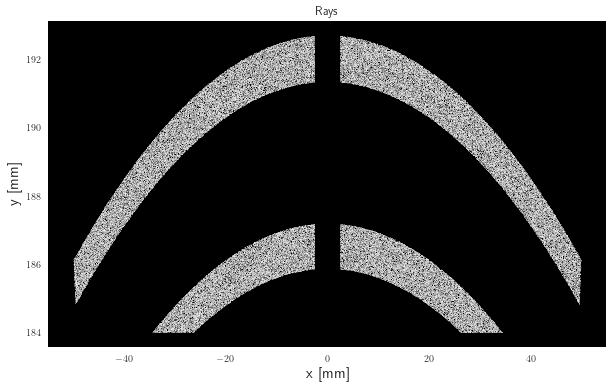

In [17]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(10,6))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [18]:
def loc_primary(rays, r_int):
    # Propagate these photons to primary mirror.
    surfaces.wolterprimary(rays, r_int.to('mm').value, z0.to('mm').value)
    
    # Find which photons interact with this mirror.
    ind = np.where((rays[3] > (z0 + mirror_sep/2).to('mm').value) &
                   (rays[3] < (z0 + mirror_sep/2 + mirror_length).to('mm').value))[0]

    # Keep only the photons which interact with the actual size
    # of the mirror
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays

In [19]:
som1 = loc_primary(som1, r_int[0])
som2 = loc_primary(som2, r_int[1])

In [20]:
alpha_p = (np.mean(analyses.grazeAngle(rays)))

print(alpha_p)

0.0


In [21]:
trans.reflect(som1)
trans.reflect(som2)

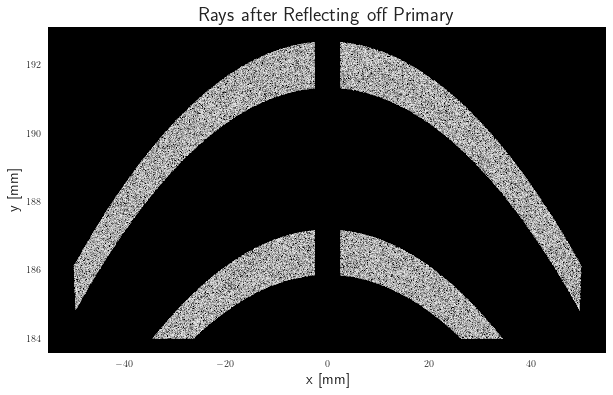

In [22]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(10,6))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Primary", fontsize=20)
    #ax1.grid()


In [23]:
def beck(num):
    ogre.beckmann_scatter(som1, 0, 0, num)
    ogre.beckmann_scatter(som2, 0, 0, num)
    
    return
    
beck(1.48e-5) 
# used to be 1.48e-5

In [24]:
def loc_secondary(rays, r_int):
    
    # Propagate photons to the secondary mirror.
    surfaces.woltersecondary(rays, r_int.to('mm').value, z0.to('mm').value)

    # Find which photons will interact with hyperboloid.
    ind = np.where((rays[3] < (z0 - mirror_sep/2).to('mm').value) &
                   (rays[3] > (z0 - mirror_sep/2 - mirror_length).to('mm').value))[0]
    
    # keep only photons which interact with mirror.
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays    

In [25]:
som1 = loc_secondary(som1, r_int[0])
som2 = loc_secondary(som2, r_int[1])

In [26]:
trans.reflect(som1)
trans.reflect(som2)

In [27]:
def gauss(num):
    
    som1[5] += np.random.normal(scale=num, size=len(som1[5]))
    som2[5] += np.random.normal(scale=num, size=len(som2[5]))


    som1[6] = -np.sqrt(1. - som1[5]**2 - som1[4]**2)
    som2[6] = -np.sqrt(1. - som2[5]**2 - som2[4]**2)

#gauss(1.2e-5)
#originally 1.2e-5

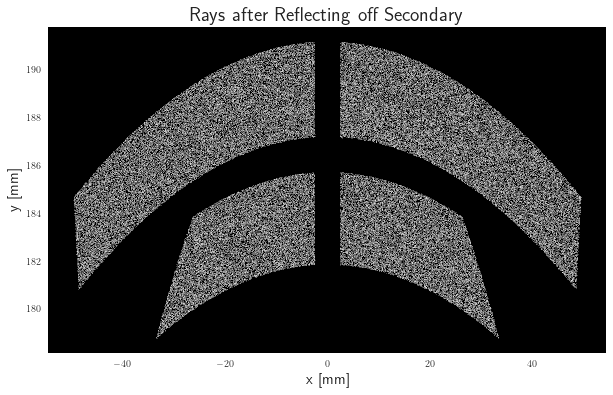

In [28]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(10,6))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Secondary", fontsize=20)
    #ax1.grid()

In [29]:
# Add to 'master' PyXFocus ray object.
new_rays = [np.append(new_rays[i], som1[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som2[i])
            for i in range(len(new_rays))]

In [30]:
rays = trans.copy_rays(new_rays)

In [31]:
z = 3500

#trans.transform(rays, 0, 0, z, 0, 0, 0)
#trans.transform(rays, 0, 0, 0, -pitch_val, 0, 0)

# Transform coordinate system to be at center of rotation.
trans.transform(rays, 0, 0, z, 0, 0, 0)
    
# Propagate rays to misaligned plane, simulating center plane of optic assembly.
surfaces.flat(rays)

# Transform the rays back by the pitch angle to the optical axis coordinate system.
trans.transform(rays, 0, 0, 0, -pitch_val, 0, 0)

# Put the rays back at the intersection plane of the ideal optic.
rays[3] = np.ones(len(rays[3])) * z


'\n\nz = 3500\n\n#trans.transform(rays, 0, 0, z, 0, 0, 0)\n#trans.transform(rays, 0, 0, 0, -pitch_val, 0, 0)\n\n# Transform coordinate system to be at center of rotation.\ntrans.transform(rays, 0, 0, z, 0, 0, 0)\n    \n# Propagate rays to misaligned plane, simulating center plane of optic assembly.\nsurfaces.flat(rays)\n\n# Transform the rays back by the pitch angle to the optical axis coordinate system.\ntrans.transform(rays, 0, 0, 0, -pitch_val, 0, 0)\n\n# Put the rays back at the intersection plane of the ideal optic.\nrays[3] = np.ones(len(rays[3])) * z\n\n'

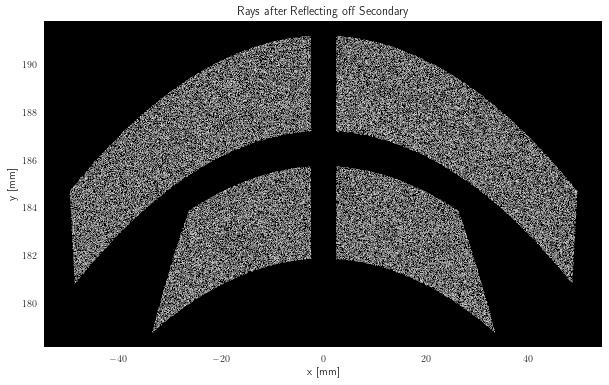

In [32]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(10,6))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Secondary")
    #ax1.grid()

In [33]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 10.11822807,  -5.64694767, -17.19605702, ..., -15.06138577,
         46.74979883,  16.25801505]),
 array([183.90976113, 185.18151155, 182.54182287, ..., 190.53125582,
        181.88581601, 188.67181448]),
 array([3458.61664226, 3485.72282395, 3437.59347162, ..., 3495.6226916 ,
        3414.49598825, 3452.82856723]),
 array([-0.00284177,  0.00157439,  0.00485899, ...,  0.004188  ,
        -0.01329909, -0.00457502]),
 array([-0.05309388, -0.05305949, -0.05303451, ..., -0.0544098 ,
        -0.05320594, -0.05454009]),
 array([-0.99858548, -0.99859011, -0.99858086, ..., -0.99850991,
        -0.998495  , -0.9985011 ]),
 array([-0.05489072,  0.03045582,  0.09371371, ...,  0.0787375 ,
        -0.24872735, -0.08578057]),
 array([-0.99769829, -0.9987439 , -0.99480197, ..., -0.99605413,
        -0.96770422, -0.99547057]),
 array([0.0398138 , 0.03978771, 0.03983436, ..., 0.040946  , 0.04102729,
        0.04098835])]

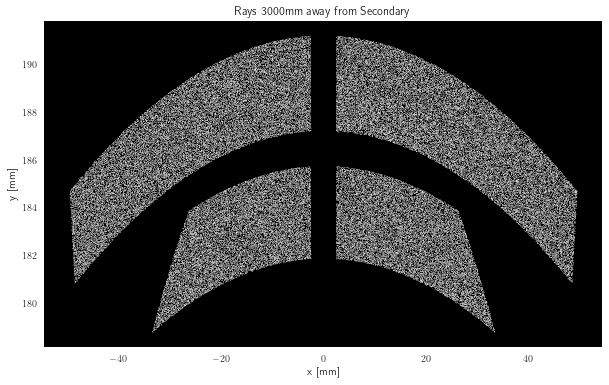

In [34]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(10,6))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays 3000mm away from Secondary")
    #ax1.grid()

In [35]:


#Go to the X-ray focus.
f0 = surfaces.focusX(rays) #put z to focus 

print(f0)


-96.22039756822005


In [36]:

cen_y = np.mean(rays[2])
print(cen_y)
trans.transform(rays, 0, cen_y, 0, 0, 0, 0)

# Copy rays to reference later.
of_rays = deepcopy(rays)

rays


-5.1450210875661035


[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00189793,  0.00038111, -0.00088416, ...,  0.00368843,
        -0.00992049, -0.0033278 ]),
 array([ 0.04735171,  0.00210487,  0.00643091, ..., -0.04682163,
        -0.04169019, -0.0391776 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00284177,  0.00157439,  0.00485899, ...,  0.004188  ,
        -0.01329909, -0.00457502]),
 array([-0.05309388, -0.05305949, -0.05303451, ..., -0.0544098 ,
        -0.05320594, -0.05454009]),
 array([-0.99858548, -0.99859011, -0.99858086, ..., -0.99850991,
        -0.998495  , -0.9985011 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

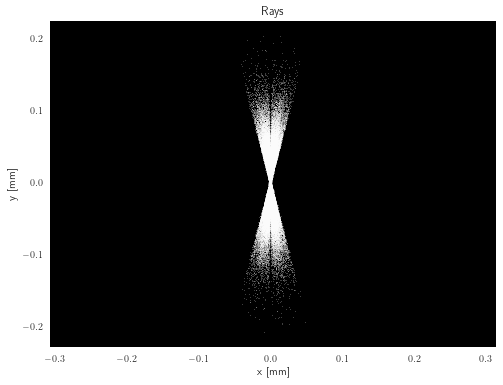

In [37]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,6))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')
    ax1.axis('equal')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [38]:
trans.transform(rays, 0, 0, 280, 0, 0, 0)

surfaces.flat(rays)
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.79872003, -0.44106976, -1.36333529, ..., -1.17070046,
         3.71943797,  1.27960073]),
 array([14.93469687, 14.87973766, 14.87719682, ..., 15.21065597,
        14.87842743, 15.25497188]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00284177,  0.00157439,  0.00485899, ...,  0.004188  ,
        -0.01329909, -0.00457502]),
 array([-0.05309388, -0.05305949, -0.05303451, ..., -0.0544098 ,
        -0.05320594, -0.05454009]),
 array([-0.99858548, -0.99859011, -0.99858086, ..., -0.99850991,
        -0.998495  , -0.9985011 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

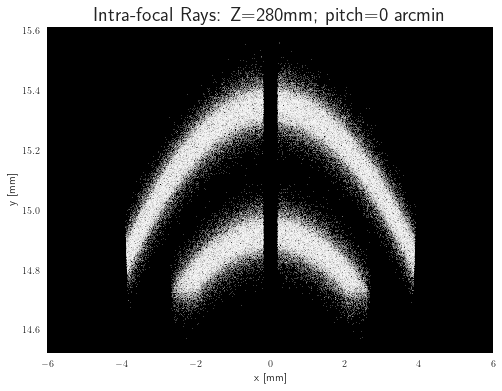

In [39]:
with sns.axes_style("ticks"):
    
    matplotlib.rc('text',usetex=True)
    matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,6))
    
    ax1.set_xlim(-6,6)
    #ax1.set_ylim(-70,10)
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Intra-focal Rays: Z=280mm; pitch=0 arcmin", fontsize=20)
    #ax1.grid
    
    

In [40]:
print(len(rays[0]))

150971
